<a href="https://colab.research.google.com/github/PurpleBeetle/IA1900/blob/main/Proyecto_IA_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Entrenando modelo de Tipo (Regresion Logistica)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Entrenando modelo de Severidad (Random Forest)...

== Evaluacion Tipo ==
Accuracy: 1.0000
Reporte:
                 precision    recall  f1-score   support

         Benign       1.00      1.00      1.00        40
     Downloader       1.00      1.00      1.00        40
Encoded Command       1.00      1.00      1.00        40
    Persistence       1.00      1.00      1.00        40
 Scheduled Task       1.00      1.00      1.00        40

       accuracy                           1.00       200
      macro avg       1.00      1.00      1.00       200
   weighted avg       1.00      1.00      1.00       200


== Evaluacion Severidad (RF) ==
Accuracy: 0.9950
Reporte:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        40
           1       0.98      1.00      0.99        42
           2       1.00      0.97      0.99        37
           3       1.00      1.00      1.00        81

    accuracy                           0.99       200


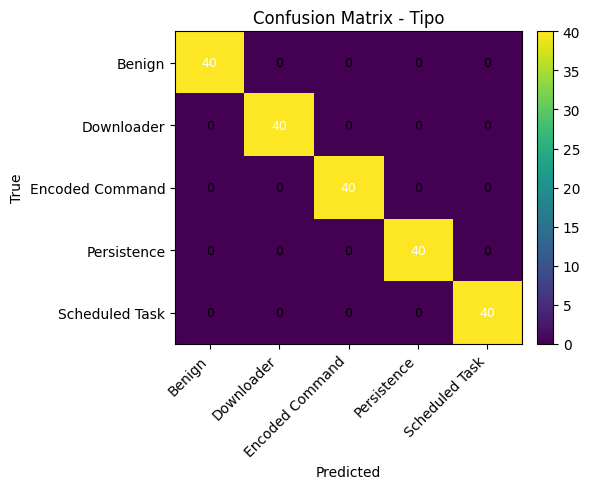

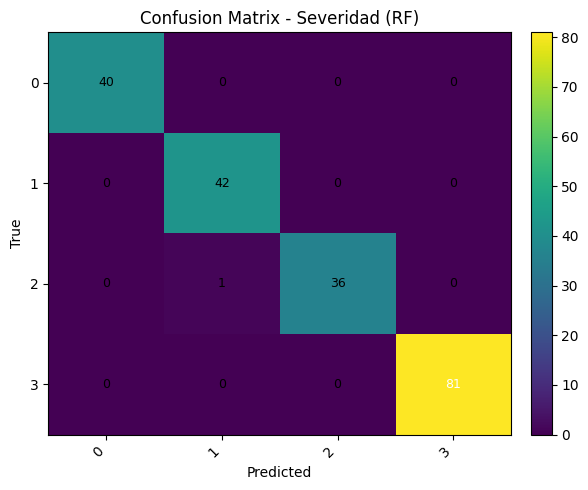


Payload de entrada:
Get-Process | Select-Object Name, Id

Probabilidades de Tipo:
  Benign          : 91.7%
  Downloader      : 2.9%
  Encoded Command : 2.2%
  Scheduled Task  : 1.8%
  Persistence     : 1.4%

Probabilidades de Severidad (RF):
0 (None  ): 99.5%
1 (Low   ): 0.5%
2 (Medium): 0.0%
3 (High  ): 0.0%

Predicciones principales:
  Tipo     -> Benign (91.7%)
  Severidad-> 0 - None (99.5%)

Payload de entrada:
powershell.exe -NoProfile -EncodedCommand SQBFAFgAIAAkAHMAdAByAGkAbgBnAA==

Probabilidades de Tipo:
  Encoded Command : 93.8%
  Benign          : 2.2%
  Scheduled Task  : 1.4%
  Downloader      : 1.4%
  Persistence     : 1.2%

Probabilidades de Severidad (RF):
3 (High  ): 100.0%
0 (None  ): 0.0%
1 (Low   ): 0.0%
2 (Medium): 0.0%

Predicciones principales:
  Tipo     -> Encoded Command (93.8%)
  Severidad-> 3 - High (100.0%)

Payload de entrada:
schtasks /Create /SC daily /TN 'Updater' /TR 'powershell -NoP -c Write-Output demo'

Probabilidades de Tipo:
  Scheduled Task  : 9

In [ ]:
# ======================================
# Clasificador de payloads PowerShell
# Dataset: powershell_payload_5types_balanced.csv
#
# Objetivo general
# - Aprender a partir de texto de payloads
# - Predecir:
#     1) Tipo (5 clases) con probabilidades
#     2) Severidad (0..3) con probabilidades
#
# Diseno de modelos
# - Tipo: Regresion Logistica multinomial
#   Razon: es rapida, estable en espacios TF-IDF de alta dimension y entrega
#           probabilidades via softmax. Suele funcionar muy bien con texto.
# - Severidad: Random Forest
#   Razon: conjunto de arboles que captura relaciones no lineales y separa mejor
#           las clases 1,2,3 que suelen solaparse en tokens. Ofrece predict_proba.
#
# Representacion de texto
# - TF-IDF de n-gramas de caracteres (3..5)
#   Razon: en comandos de PowerShell abundan simbolos, rutas y flags.
#          Los n-gramas de caracteres capturan patrones cortos tipo "-enc", "HKCU",
#          "schtasks", etc., mejor que los n-gramas de palabras.
# ======================================

ruta_csv = 'powershell_payload_5types_balanced_SEVCONSISTENT.csv'

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 1) Carga de datos
#    Verificamos columnas requeridas y ajustamos tipos.
datos = pd.read_csv(ruta_csv)
assert {'Payload','Type','Severity'}.issubset(datos.columns), "El CSV debe contener Payload, Type, Severity"

texto = datos['Payload'].astype(str)    # entrada de texto crudo
etiqueta_tipo = datos['Type'].astype(str)   # etiqueta multinomial de tipo
etiqueta_sev = datos['Severity'].astype(int)  # etiqueta 0..3 de severidad

# 2) Particion de entrenamiento y prueba
#    Usamos una sola particion para ambos modelos para comparar sobre el mismo conjunto.
#    Estratificamos por tipo para preservar proporcion de clases en test.
X_entren, X_prueba, ytipo_entren, ytipo_prueba, ysev_entren, ysev_prueba = train_test_split(
    texto, etiqueta_tipo, etiqueta_sev, test_size=0.2, random_state=42, stratify=etiqueta_tipo
)

# 3) Vectorizador TF-IDF de n-gramas de caracteres
#    min_df y max_df filtran ruido (terminos extremadamente raros o muy comunes).
vectorizador_tfidf = TfidfVectorizer(
    analyzer='char',
    ngram_range=(3,5),
    min_df=2,
    max_df=0.95
)

# 4A) Modelo de TIPO: Regresion Logistica multinomial
#     Logica: softmax modela la prob de cada clase. Solver SAGA es eficiente y estable.
tuberia_tipo = Pipeline([
    ('tfidf', vectorizador_tfidf),
    ('clf', LogisticRegression(
        max_iter=2000,
        solver='saga',
        n_jobs=-1,
        multi_class='multinomial'
    ))
])

# 4B) Modelo de SEVERIDAD: Random Forest
#     Logica: varios arboles con muestreo aleatorio reducen varianza y capturan interacciones.
#             class_weight balanced ayuda si hay leve desbalance.
tuberia_sev = Pipeline([
    ('tfidf', vectorizador_tfidf),
    ('clf', RandomForestClassifier(
        n_estimators=200,        # subir si necesitas mas calidad; bajar si quieres mas velocidad
        max_depth=None,          # sin limite; puedes fijar p.e. 40 para controlar complejidad
        min_samples_leaf=1,      # subir a 2 o 3 para suavizar y evitar sobreajuste
        class_weight='balanced',
        n_jobs=-1,
        random_state=42
    ))
])

print("Entrenando modelo de Tipo (Regresion Logistica)...")
tuberia_tipo.fit(X_entren, ytipo_entren)

print("Entrenando modelo de Severidad (Random Forest)...")
tuberia_sev.fit(X_entren, ysev_entren)

# 5) Evaluacion en prueba
pred_tipo = tuberia_tipo.predict(X_prueba)
pred_sev = tuberia_sev.predict(X_prueba)

print("\n== Evaluacion Tipo ==")
print("Accuracy:", f"{accuracy_score(ytipo_prueba, pred_tipo):.4f}")
print("Reporte:")
print(classification_report(ytipo_prueba, pred_tipo))

print("\n== Evaluacion Severidad (RF) ==")
print("Accuracy:", f"{accuracy_score(ysev_prueba, pred_sev):.4f}")
print("Reporte:")
print(classification_report(ysev_prueba, pred_sev, labels=[0,1,2,3]))

# 6) Funcion para graficar matriz de confusion
def graficar_matriz_confusion(matriz, clases, titulo):
    # Dibuja la matriz de confusion con anotaciones
    fig, ax = plt.subplots(figsize=(6, 5))
    imagen = ax.imshow(matriz, interpolation='nearest', aspect='auto')
    ax.set_title(titulo)
    ax.set_xticks(np.arange(len(clases)))
    ax.set_yticks(np.arange(len(clases)))
    ax.set_xticklabels(clases, rotation=45, ha="right")
    ax.set_yticklabels(clases)
    # anotaciones por celda
    for i in range(matriz.shape[0]):
        for j in range(matriz.shape[1]):
            ax.text(j, i, str(matriz[i, j]),
                    ha="center", va="center", fontsize=9,
                    color="white" if matriz[i, j] > matriz.max()*0.6 else "black")
    fig.colorbar(imagen, ax=ax, fraction=0.046, pad=0.04)
    ax.set_ylabel('True')
    ax.set_xlabel('Predicted')
    fig.tight_layout()
    plt.show()

# Matriz de confusion de TIPO
etiquetas_tipo_orden = sorted(etiqueta_tipo.unique().tolist(), key=lambda x: x)
mc_tipo = confusion_matrix(ytipo_prueba, pred_tipo, labels=etiquetas_tipo_orden)
graficar_matriz_confusion(mc_tipo, etiquetas_tipo_orden, "Confusion Matrix - Tipo")

# Matriz de confusion de SEVERIDAD
etiquetas_sev_orden = [0,1,2,3]
mc_sev = confusion_matrix(ysev_prueba, pred_sev, labels=etiquetas_sev_orden)
graficar_matriz_confusion(mc_sev, [str(s) for s in etiquetas_sev_orden], "Confusion Matrix - Severidad (RF)")

# 7) Prediccion con porcentajes para un payload nuevo
#    Usamos predict_proba para entregar porcentajes por clase para interpretacion.
nombres_sev = {0: "None", 1: "Low", 2: "Medium", 3: "High"}

def predecir_con_porcentajes(payload: str):
    # Probabilidades de TIPO (Regresion Logistica)
    proba_tipo = tuberia_tipo.predict_proba([payload])[0]
    clases_tipo = tuberia_tipo.named_steps['clf'].classes_

    # Probabilidades de SEVERIDAD (Random Forest)
    proba_sev = tuberia_sev.predict_proba([payload])[0]
    clases_sev = tuberia_sev.named_steps['clf'].classes_

    # Tablas ordenadas de mayor a menor probabilidad
    tabla_tipo = sorted([(c, p) for c, p in zip(clases_tipo, proba_tipo)], key=lambda x: x[1], reverse=True)
    tabla_sev = sorted([(int(c), p) for c, p in zip(clases_sev, proba_sev)], key=lambda x: x[1], reverse=True)

    # Predicciones top
    mejor_tipo, mejor_tipo_p = tabla_tipo[0]
    mejor_sev, mejor_sev_p = tabla_sev[0]

    print("\nPayload de entrada:")
    print(payload[:200] + ("..." if len(payload) > 200 else ""))

    print("\nProbabilidades de Tipo:")
    for c, p in tabla_tipo:
        print(f"  {c:16s}: {p*100:.1f}%")

    print("\nProbabilidades de Severidad (RF):")
    for c, p in tabla_sev:
        print(f"{c} ({nombres_sev.get(c,'?'):6s}): {p*100:.1f}%")

    print("\nPredicciones principales:")
    print(f"  Tipo     -> {mejor_tipo} ({mejor_tipo_p*100:.1f}%)")
    print(f"  Severidad-> {mejor_sev} - {nombres_sev[mejor_sev]} ({mejor_sev_p*100:.1f}%)")

# 8) Demostracion rapida con ejemplos

# Ejemplo con un input
#user_payload = input("Enter a PowerShell payload to classify: ")
#redecir_con_porcentajes(user_payload)

ejemplos = [
    "Get-Process | Select-Object Name, Id",
    "powershell.exe -NoProfile -EncodedCommand SQBFAFgAIAAkAHMAdAByAGkAbgBnAA==",
    "schtasks /Create /SC daily /TN 'Updater' /TR 'powershell -NoP -c Write-Output demo'",
    "Invoke-WebRequest -Uri 'https://example.org/script.ps1' -UseBasicParsing",
    "New-ItemProperty -Path 'HKCU:\\Software\\Microsoft\\Windows\\CurrentVersion\\Run' -Name Updater -Value 'powershell -NoP -c Write-Output demo'"
]
for ej in ejemplos:
    predecir_con_porcentajes(ej)
